In [17]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

PTHREADS_CSV = os.path.join(os.getcwd(), '1_1_polynomial_multiplication', 'results_1.1.csv')
OPENMP_CSV = os.path.join(os.getcwd(), '2_1_polynomial_multiplication', 'results_2.1.csv')
PLOTS_DIR = os.path.join(os.getcwd(), 'comparison_plots')
os.makedirs(PLOTS_DIR, exist_ok=True)

pthreads = pd.read_csv(PTHREADS_CSV)
openmp = pd.read_csv(OPENMP_CSV)

if 'user' not in pthreads.columns:
    pthreads['user'] = 'unknown'
if 'user' not in openmp.columns:
    openmp['user'] = 'unknown'

pthreads['degree'] = pthreads['degree'].astype(int)
openmp['degree'] = openmp['degree'].astype(int)

def threads_to_int(x):
    if str(x).lower() == 'sequential':
        return -1
    try:
        return int(x)
    except Exception:
        return 1

pthreads['threads_int'] = pthreads['threads'].apply(threads_to_int)
openmp['threads_int'] = openmp['threads'].apply(threads_to_int)

In [18]:
def compute_openmp_vs_pthreads_speedup(pthreads_df, openmp_df, user):
    pthreads_user = pthreads_df[pthreads_df['user'] == user].copy()
    openmp_user = openmp_df[openmp_df['user'] == user].copy()
    
    if pthreads_user.empty or openmp_user.empty:
        return None
    
    pthreads_user = pthreads_user[pthreads_user['threads_int'] >= 0]
    openmp_user = openmp_user[openmp_user['threads_int'] >= 0]
    
    merged = pthreads_user.merge(
        openmp_user,
        on=['degree', 'threads_int'],
        suffixes=('_pthreads', '_openmp')
    )
    
    merged['speedup'] = merged['time_total_pthreads'] / merged['time_total_openmp']
    
    stats = merged.groupby(['degree', 'threads_int'])['speedup'].agg(['mean', 'std']).reset_index()
    stats['std'] = stats['std'].fillna(0)
    
    return stats

In [19]:
def plot_openmp_vs_pthreads_speedup(pthreads_df, openmp_df, user):
    stats = compute_openmp_vs_pthreads_speedup(pthreads_df, openmp_df, user)
    if stats is None or stats.empty:
        return
    
    degrees = sorted(stats['degree'].unique())
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(degrees)))
    
    jitter_amount = 0.3
    offsets = np.linspace(-jitter_amount * (len(degrees)-1)/2, 
                          jitter_amount * (len(degrees)-1)/2, 
                          len(degrees))
    
    for idx, degree in enumerate(degrees):
        degree_stats = stats[stats['degree'] == degree]
        
        threads = degree_stats['threads_int'].values + offsets[idx]
        
        ax.errorbar(threads, degree_stats['mean'].values, 
                   yerr=degree_stats['std'].values,
                   marker='o', capsize=5, linewidth=2, markersize=8,
                   color=colors[idx], label=f'degree={degree}')
    
    ax.axhline(y=1.0, color='r', linestyle='--', alpha=0.5, linewidth=2, label='No speedup (1.0x)')
    
    threads_all = sorted(stats['threads_int'].unique())
    threads_labels = ['seq' if t == -1 else str(t) for t in threads_all]
    
    ax.set_xlabel('Threads', fontsize=12)
    ax.set_ylabel('Speedup (Pthreads / OpenMP)', fontsize=12)
    ax.set_title(f'OpenMP vs Pthreads Performance - User: {user}', fontsize=14)
    ax.set_xticks(threads_all)
    ax.set_xticklabels(threads_labels)
    
    if user == 'marr':
        ax.set_ylim(None, 3)
    
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=10)
    
    plt.tight_layout()
    
    output_file = os.path.join(PLOTS_DIR, f'openmp_vs_pthreads_speedup_{user}.png')
    plt.savefig(output_file, dpi=150, bbox_inches='tight')
    print(f'Saved: {output_file}')
    plt.show()

Found 3 common users: ['ea24205', 'marr', 'phoebus']

Processing user: ea24205
Saved: /home/marr/threads/Thread-Experiments/comparison_plots/openmp_vs_pthreads_speedup_ea24205.png


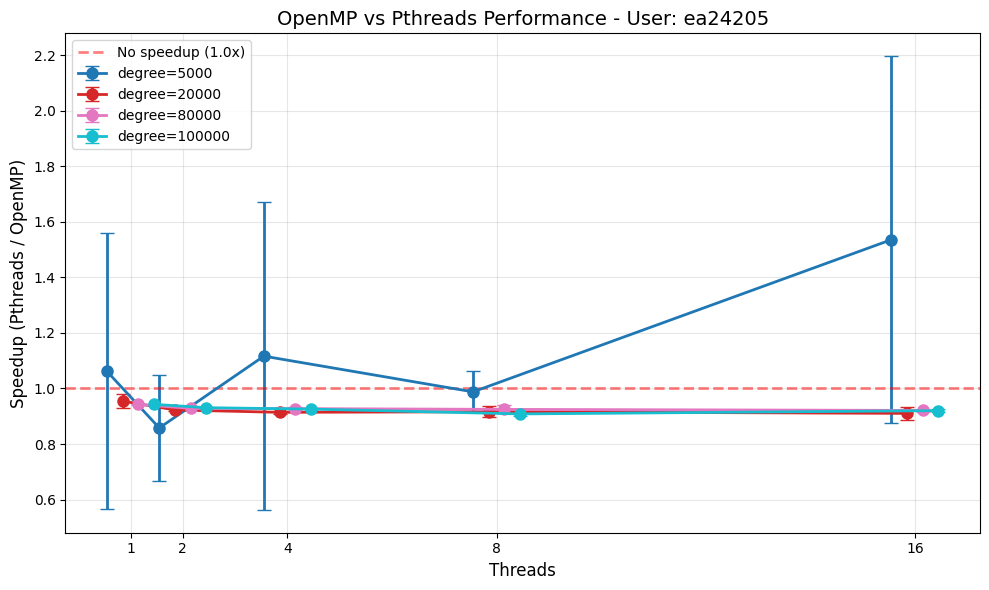

Processing user: marr
Saved: /home/marr/threads/Thread-Experiments/comparison_plots/openmp_vs_pthreads_speedup_marr.png


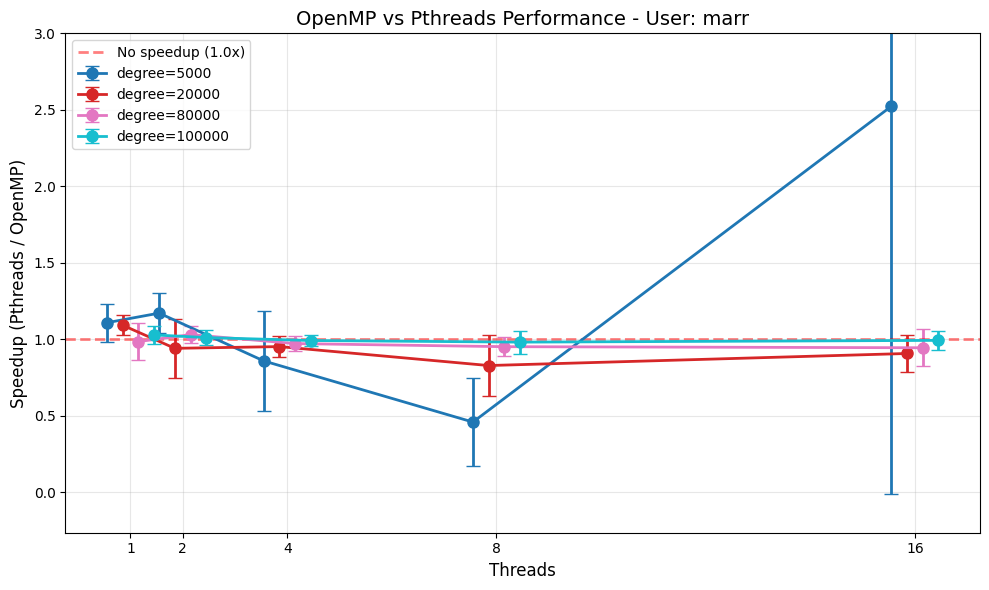

Processing user: phoebus
Saved: /home/marr/threads/Thread-Experiments/comparison_plots/openmp_vs_pthreads_speedup_phoebus.png


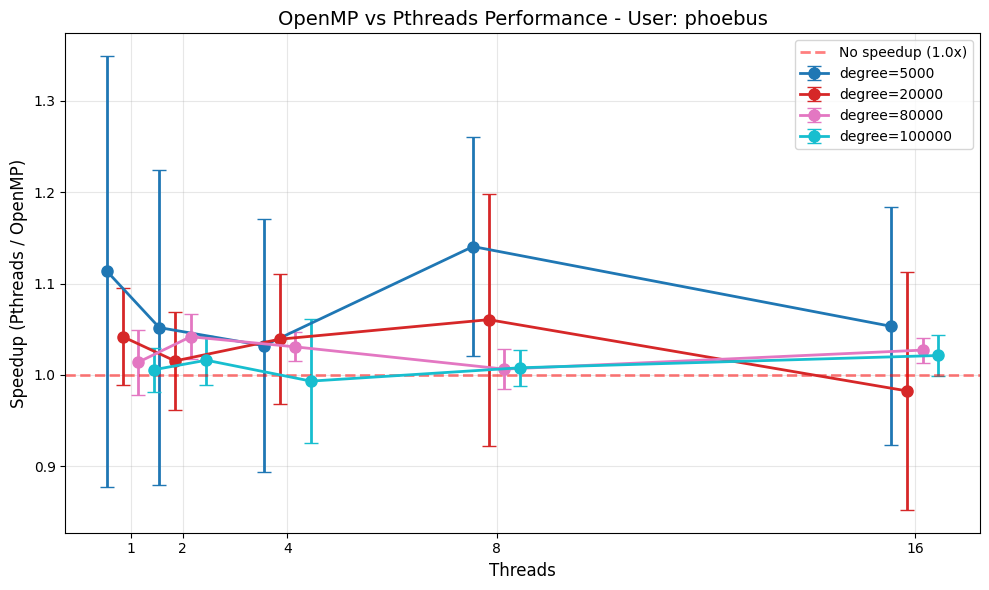

In [20]:
users = set(pthreads['user'].unique()) & set(openmp['user'].unique())
users = sorted(users)

print(f'Found {len(users)} common users: {users}\n')

for user in users:
    print(f'Processing user: {user}')
    plot_openmp_vs_pthreads_speedup(pthreads, openmp, user)